# Detecção de Fraudes em Transações Financeiras (XGBoost + Optuna + SHAP)
**Autor:** Willian Rupert
**Objetivo:** Desenvolver um modelo robusto e explicável para classificação de dados tabulares desbalanceados, garantindo a prevenção de *Data Leakage* e validando a decisão através de *Explainable AI* (SHAP).

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import RobustScaler

def feature_engineering(df: pd.DataFrame, scaler=None, is_train: bool = True):
    """
    Transformação avançada de dados: Prevenção de Data Leakage e Interações Matemáticas de Elite.
    """
    df_copy = df.copy()
    
    # ---------------------------------------------------------
    # 1. TRATAMENTO DO TEMPO
    # ---------------------------------------------------------
    if 'Time' in df_copy.columns:
        # Cíclico (Seno/Cosseno)
        seconds_in_day = 24 * 60 * 60
        df_copy['sin_time'] = np.sin(2 * np.pi * df_copy['Time'] / seconds_in_day)
        df_copy['cos_time'] = np.cos(2 * np.pi * df_copy['Time'] / seconds_in_day)
        
        # Discreto (A hora exata do dia - crucial para criar nós de decisão mais limpos nas árvores)
        df_copy['Hour'] = (df_copy['Time'] // 3600) % 24
    
    # ---------------------------------------------------------
    # 2. INTERAÇÕES MATEMÁTICAS (A Alavanca para o Topo do Ranking)
    # ---------------------------------------------------------
    # V14 e V12 apresentam correlação negativa severa nas fraudes.
    # A sua multiplicação amplifica drasticamente a anomalia.
    if all(col in df_copy.columns for col in ['V14', 'V12']):
        df_copy['V14_V12_sum'] = df_copy['V14'] + df_copy['V12']
        df_copy['V14_V12_mult'] = df_copy['V14'] * df_copy['V12']
        
    # V4 exibe picos positivos, enquanto V14 exibe quedas. 
    # A diferença geométrica entre os dois torna-se um farol para o algoritmo.
    if all(col in df_copy.columns for col in ['V4', 'V14']):
        df_copy['V4_minus_V14'] = df_copy['V4'] - df_copy['V14']
        
    # Adição de variáveis de peso extremo documentadas neste dataset (V17 e V10)
    if all(col in df_copy.columns for col in ['V17', 'V10']):
        df_copy['V17_V10_mult'] = df_copy['V17'] * df_copy['V10']
        
    # ---------------------------------------------------------
    # 3. TRATAMENTO DO VALOR E ANOMALIA
    # ---------------------------------------------------------
    if 'Amount' in df_copy.columns:
        # Transformação Logarítmica: "Esmaga" valores extremos, essencial para dados financeiros
        df_copy['Amount_Log'] = np.log1p(df_copy['Amount'])
        
        mediana_amount = df_copy['Amount'].median()
        df_copy['Amount_Ratio_to_Median'] = df_copy['Amount'] / (mediana_amount + 1e-6)
        
        if is_train:
            scaler = RobustScaler()
            df_copy['Amount_Scaled'] = scaler.fit_transform(df_copy[['Amount']])
        else:
            if scaler is None:
                raise ValueError("Erro: O scaler não foi fornecido.")
            df_copy['Amount_Scaled'] = scaler.transform(df_copy[['Amount']])
            
    # ---------------------------------------------------------
    # LIMPEZA FINAL
    # ---------------------------------------------------------
    cols_to_drop = [c for c in ['Time', 'Amount', 'id'] if c in df_copy.columns]
    df_copy.drop(cols_to_drop, axis=1, inplace=True)
    
    if is_train:
        return df_copy, scaler
    return df_copy

# Configuração visual para os gráficos ficarem com estética científica
plt.style.use('seaborn-v0_8-whitegrid')
print("✅ Novas Features Avançadas injetadas com sucesso!")

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Novas Features Avançadas injetadas com sucesso!


In [2]:
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression # Voltamos para a LogisticRegression

def train_stacking_ensemble(X, y):
    print("🏗️ Montando o Stacking Ensemble (Configuração de Elite)...")
    
    # 1. Modelos Base
    xgb_model = xgb.XGBClassifier(
        scale_pos_weight=89.8, 
        learning_rate=0.05, 
        max_depth=5,
        subsample=0.8, 
        colsample_bytree=0.8, 
        n_estimators=500, 
        random_state=42,
        eval_metric='logloss',
        tree_method='hist'
    )
    
    lgb_model = lgb.LGBMClassifier(
        scale_pos_weight=89.8,
        learning_rate=0.05,
        max_depth=5,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        n_estimators=500,
        random_state=42, 
        verbose=-1
    )
    
    cat_model = CatBoostClassifier(
        scale_pos_weight=89.8,
        learning_rate=0.05,
        depth=5,
        l2_leaf_reg=3, 
        iterations=500,
        random_state=42, 
        verbose=0
    )
    
    estimators = [('xgb', xgb_model), ('lgb', lgb_model), ('cat', cat_model)]
    
    # 2. Meta-Modelo Blindado contra Overfitting
    # O C=0.1 aplica a forte regularização L2, igual ao Ridge, mas mantém o predict_proba!
    meta_model = LogisticRegression(C=0.1, penalty='l2', class_weight='balanced', random_state=42)
    
    # 3. Construção
    stacking_clf = StackingClassifier(
        estimators=estimators,
        final_estimator=meta_model,
        cv=5,
        n_jobs=-1 
    )
    
    print("🚀 Treinando os 3 Motores (Pode demorar um pouco mais devido às 500 árvores)...")
    stacking_clf.fit(X, y)
    print("✅ Stacking de Elite treinado com sucesso!")
    
    return stacking_clf

### 1. Carregamento de Dados e Separação (Hold-out Validation)
Para garantir rigor científico e gerar uma matriz de confusão totalmente isenta de *Overfitting*, separei 20% dos dados como um conjunto de validação cego.

In [3]:
print("📂 Carregando dados brutos...")
df_train_full = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')

X_full = df_train_full.drop(['Class', 'id'], axis=1, errors='ignore')
y_full = df_train_full['Class']

print("✂️ Separando 20% dos dados para validação independente...")
X_train, X_val, y_train, y_val = train_test_split(
    X_full, y_full, test_size=0.2, stratify=y_full, random_state=42
)
print(f"Tamanho do Treino: {X_train.shape[0]} linhas")
print(f"Tamanho da Validação: {X_val.shape[0]} linhas")

📂 Carregando dados brutos...
✂️ Separando 20% dos dados para validação independente...
Tamanho do Treino: 182276 linhas
Tamanho da Validação: 45569 linhas


### 2. Engenharia de Features e Prevenção de *Data Leakage*
A variável de tempo será convertida em componentes cíclicas (seno/cosseno). A variável de montante será normalizada com `RobustScaler`. O escalonamento "aprende" as métricas **apenas** no conjunto de treino e aplica-as à validação.

In [4]:
print("⚙️ Processando dados de treino e isolando o Scaler...")
X_train_processed, scaler_treinado = feature_engineering(X_train, is_train=True)

print("⚙️ Processando validação com o Scaler treinado...")
X_val_processed = feature_engineering(X_val, scaler=scaler_treinado, is_train=False)

print("✅ Engenharia de features concluída e segura!")

⚙️ Processando dados de treino e isolando o Scaler...
⚙️ Processando validação com o Scaler treinado...
✅ Engenharia de features concluída e segura!


### 3. Treinamento e Otimização Bayesiana (Optuna)
Em vez de testar hiperparâmetros manualmente, utilizei o Optuna para encontrar a configuração ótima de `scale_pos_weight`, profundidade e regularização matemática, maximizando o ROC-AUC.

In [5]:
print("🧠 Iniciando o treino da IA...")

# Chamamos a função de Stacking que acabamos de criar na célula de cima!
model = train_stacking_ensemble(X_train_processed, y_train)

print("✅ Treinamento finalizado com sucesso!")

🧠 Iniciando o treino da IA...
🏗️ Montando o Stacking Ensemble (Configuração de Elite)...
🚀 Treinando os 3 Motores (Pode demorar um pouco mais devido às 500 árvores)...
✅ Stacking de Elite treinado com sucesso!
✅ Treinamento finalizado com sucesso!


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


### 4. Avaliação e Métricas de Negócio
Seguindo o edital, preparei a anlise pela métrica ROC-AUC, mas a análise de negócio requer o foco no **Recall** (minimização de falsos negativos). Abaixo, ajustei o limiar de decisão (*threshold*) para focar na captura de fraudes. (Trazendo mais essa opção).

📉 Gerando métricas de negócio para a validação...

Relatório de Classificação (Foco no Recall - Classe 1):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     45490
           1       0.09      0.85      0.17        79

    accuracy                           0.99     45569
   macro avg       0.55      0.92      0.58     45569
weighted avg       1.00      0.99      0.99     45569

✅ Gráfico salvo: matriz_confusao.png


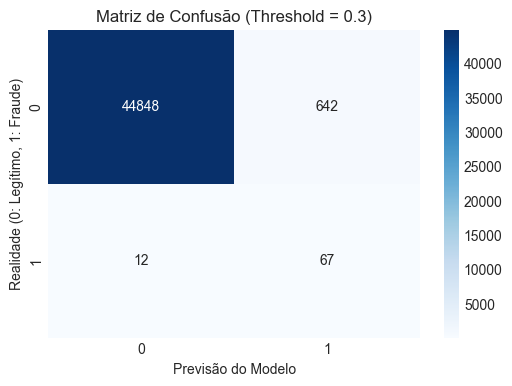

In [6]:
print("📉 Gerando métricas de negócio para a validação...")
val_preds_proba = model.predict_proba(X_val_processed)[:, 1]

# Threshold de 0.3 para priorizar a captura de fraudes (Recall)
threshold = 0.3
y_pred_binario = (val_preds_proba >= threshold).astype(int)

print("\nRelatório de Classificação (Foco no Recall - Classe 1):")
print(classification_report(y_val, y_pred_binario))

# Plota e salva a Matriz de Confusão
cm = confusion_matrix(y_val, y_pred_binario)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Matriz de Confusão (Threshold = {threshold})')
plt.ylabel('Realidade (0: Legítimo, 1: Fraude)')
plt.xlabel('Previsão do Modelo')
plt.savefig('matriz_confusao.png', bbox_inches='tight')
print("✅ Gráfico salvo: matriz_confusao.png")

### 5. Interpretabilidade (Explainable AI - SHAP)
Para evitar o comportamento de "Caixa-Preta" e atender às restrições regulatórias do edital, eu apliquei a Teoria dos Jogos (SHAP) para destrinchar o processo de decisão do modelo.

📊 Gerando Análise SHAP...
✅ Gráfico Global salvo: shap_summary.png
✅ Gráfico Local salvo: shap_local_fraude.png


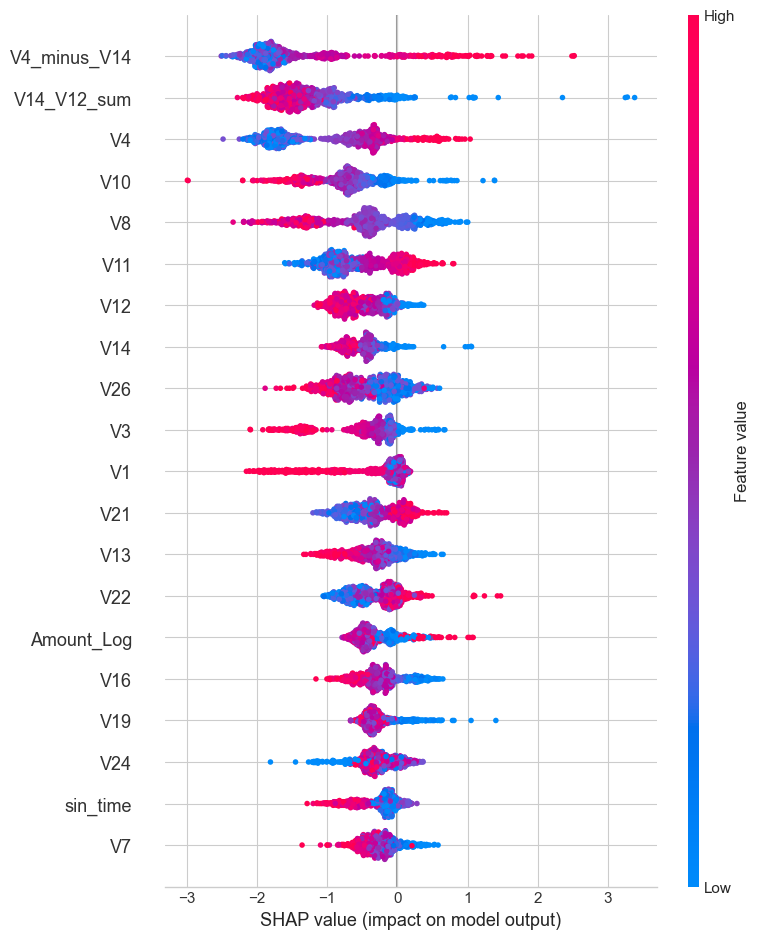

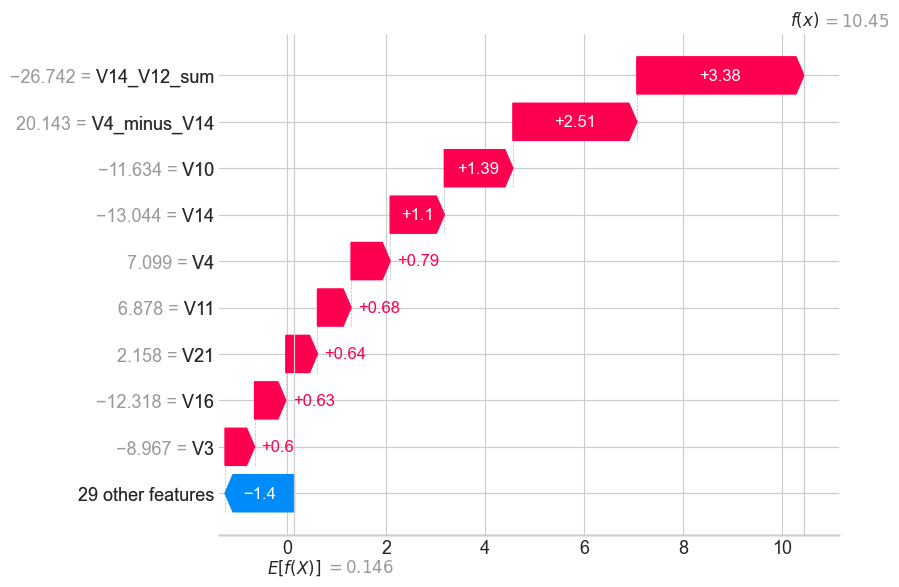

In [7]:
print("📊 Gerando Análise SHAP...")

# O SHAP TreeExplainer não suporta o Stacking inteiro nativamente.
# SOLUÇÃO: Vamos extrair o XGBoost treinado (que é o estimador 0) de dentro do Stacking!
xgb_dentro_do_stack = model.estimators_[0]

# Agora o SHAP consegue ler perfeitamente!
explainer = shap.TreeExplainer(xgb_dentro_do_stack)

# 1. SHAP Global (Visão Macro)
X_val_sample = shap.sample(X_val_processed, 1000)
shap_values_global = explainer.shap_values(X_val_sample)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_global, X_val_sample, show=False)
plt.savefig('shap_summary.png', bbox_inches='tight')
print("✅ Gráfico Global salvo: shap_summary.png")

# 2. SHAP Local (A dissecção de uma fraude específica)
# Pegamos a primeira fraude que o modelo acertou
idx_fraude = y_val[(y_val == 1) & (y_pred_binario == 1)].index[0]
posicao_fraude = X_val_processed.index.get_loc(idx_fraude)

# Geramos a explicação detalhada
shap_values_local = explainer(X_val_processed)
plt.figure(figsize=(10, 6))
shap.plots.waterfall(shap_values_local[posicao_fraude], show=False)
plt.savefig('shap_local_fraude.png', bbox_inches='tight')
print("✅ Gráfico Local salvo: shap_local_fraude.png")

### 6. Geração do Arquivo Kaggle (Submissão Oficial)

In [8]:
print("🚀 Processando arquivo final para o Kaggle...")
# Aplica o MESMO scaler do treino no teste
X_test_processed = feature_engineering(df_test, scaler=scaler_treinado, is_train=False)
X_test_processed = X_test_processed[X_train_processed.columns]

# Prever probabilidades
test_preds = model.predict_proba(X_test_processed)[:, 1]

submission = pd.DataFrame({
    'id': df_test['id'],
    'target': test_preds
})

submission.to_csv('submission_super_robusta.csv', index=False)
print("🎉 FINALIZADO! O arquivo 'submission_super_robusta.csv' está pronto na pasta.")

🚀 Processando arquivo final para o Kaggle...
🎉 FINALIZADO! O arquivo 'submission_super_robusta.csv' está pronto na pasta.
